In [73]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [76]:
experimentdir1 = rd.datadir/'flow'/'2022.08.20_4Cassette-Reprogramming'
experimentdir2 = rd.datadir/'flow'/'2022.10.31_Cassette_NTs_Reprogramming'
experimentdir3 = rd.datadir/'flow'/'2024.03.11_6-cassette_reprogramming'

experimentdir_WB = rd.datadir/'western-blot'/'2024.09.20_Western-Blot_cassette'

outputdir = rd.rootdir/'figures'/'Cassette_reprogramming_&_WB'

In [4]:
# rd.plot.plot_well_metadata(experimentdir1/'metadata.yaml')
# rd.plot.plot_well_metadata(experimentdir2/'metadata.yaml')
# rd.plot.plot_well_metadata(experimentdir3/'metadata.yaml')

# Load Data

In [77]:
data_columns = ['GFP-A']

df1 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df2 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv',yaml_path=experimentdir2/'metadata.yaml',columns=data_columns)
df3 = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv',yaml_path=experimentdir3/'metadata.yaml',columns=data_columns)

df1['rep'] = '2022.08.20'
df2['rep'] = '2022.10.31'
df3['rep'] = '2024.03.11'

df = pd.concat([df1,df2,df3])


In [79]:
df_WB = pd.read_csv(experimentdir_WB/'2024.09.20_Western.csv')


Get rid of negative values

In [80]:

for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]


# iMN Gate

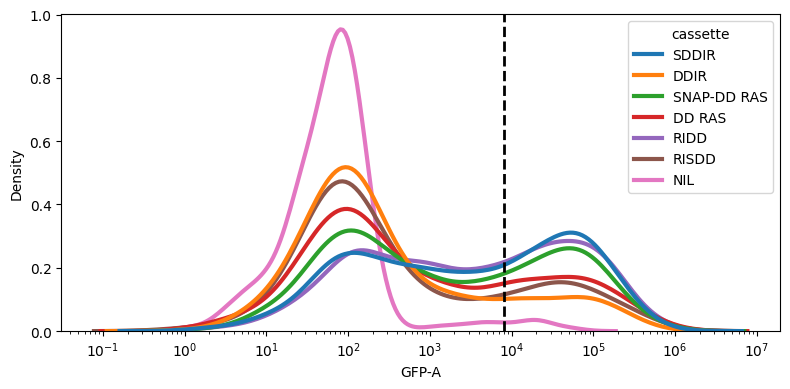

In [12]:
GFP_gate = 8 * 10**3 # Set gate at 8 * 10^3


# Plot gate
plt.figure(figsize=(8,4))
g = sns.kdeplot(data=df.sample(10000),x='GFP-A',hue='cassette',log_scale=True,common_norm=False,linewidth=3)
plt.axvline(x=GFP_gate,linestyle='--',color='black',linewidth=2)
plt.tight_layout()
plt.show()


# Make summary statistics dataframe

In [81]:
# Make a dataframe with summary statistics such as mean fluorescent intensity (MFI)
groups = ['cassette','well','rep']

summary_df = pd.concat([
    df.groupby(groups)['GFP-A'].apply(lambda x: np.mean(x > GFP_gate)*100).rename('(%) iMN\nof all cells'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)).rename('iMN Yield'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)/10000 * 100).rename('(%) iMN yield\nper MEF plated'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.size(x)).rename('Single Cells Count')
    ], axis=1)
summary_df = summary_df.reset_index()

# Change cassette names
mod_names = {'DD RAS':'DD +R',
             'SNAP-DD RAS':'SDD +R'}
summary_df['mod_names'] = summary_df['cassette'].map(mod_names).fillna(summary_df['cassette'])
df_WB['mod_names'] = df_WB['cassette'].map(mod_names).fillna(df_WB['cassette'])

# Plotting Functions

In [15]:
def custom_barplot(x,y,data,filename,height=4,width=8,hue=None,xlabel_rot=90,xlabel='',plottitle='',palette='viridis',order=None,hue_order=None,pairs=None,alpha=0.8,reps=None):
    aspect = width / height
    g = sns.catplot(x=x,y=y,data=data,height=height,aspect=aspect,palette=palette,kind='bar',hue=hue,order=order,hue_order=hue_order,alpha=alpha,errorbar='ci',legend=None)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 4)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = True

    if reps is None:
        g.map_dataframe(sns.stripplot, x=x,y=y, 
                    hue=hue, palette=["#404040"], 
                    alpha=0.8, dodge=dodge,order=order,hue_order=hue_order)
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X']

    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=x, y=y,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                palette=['white'], size=5,
                edgecolor='black', linewidth=0.4,
                legend=None)

    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=x,y=y,order=order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside', verbose=2)
        annotator.apply_and_annotate()
        #add_stat_annotation(ax, data=data, x=xcat, y=ycat, order=order,
        #            box_pairs=pairs,
        #            test='t-test_ind', text_format='star', verbose=2)

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
        ax.yaxis.set_major_formatter(k_formatter)

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make plot bounded on all sides
    
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.title(plottitle)

    if hue is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)  # Adjust bbox_to_anchor as needed

    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)


def custom_catplot(xcat,ycat,dataslice,savetitle,height=4,width=8,xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None,color=None):
    if palette != None:
        hue = xcat
        color = None
    elif palette == None:
        hue = None
    aspect = width / height
    g = sns.catplot(x=xcat,y=ycat,data=dataslice,height=height,aspect=aspect,zorder=1,palette=palette,order=order,hue=hue,color=color,s=70)
    g.map_dataframe(sns.pointplot, x=xcat,y=ycat,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    #sns.pointplot(x=xcat,y=ycat,data=dataslice,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    ax = plt.gca()
    
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))  # this is for if you want scientific y axis labels (e.g. 10^4 instead of 10000)
    if order != None:
        #labels = [ '\n'.join(wrap(l, 16)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if pairs != None:
        annotator = Annotator(g.ax,pairs,data=dataslice,x=xcat,y=ycat,order=order)
        annotator.configure(test='Kruskal',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make all plot areas the same size
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    plt.legend([],[], frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)
    plt.show()


def custom_hist(xcat,data,order,hue,savetitle=None,palette='muted',gate=None,xlim=[10,5*10**4]):
    plt.figure(figsize=(8,4))
    if xcat in ['FSC-A','FSC-H']:
        log = False
        plt.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    else:
        log = True
    g = sns.kdeplot(data=data,x=xcat,hue=hue,log_scale=log,common_norm=False,hue_order=order,palette=palette, linewidth=2.5,fill=True,alpha=0.08)

    if gate is not None:
        plt.axvline(x=gate,linestyle='--',color='black',linewidth=2.5)

    sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    plt.xlim(xlim)
    plt.title('4 dpi')
    plt.xlabel(xcat)
    plt.tight_layout()
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)
    plt.show()


def scatter(xcat,ycat,data,order,hue,savetitle,figsize=(7,4),palette='muted',sci=None,log='none',xlim=None,ylim=None):
    xcatSEM = xcat + ' SEM'
    ycatSEM = ycat + ' SEM'

    # Make the figure
    fig, ax = plt.subplots(figsize=figsize)
    plt.errorbar(x=xcat, y=ycat, xerr=xcatSEM, 
                yerr=ycatSEM,data=data, capsize=2, elinewidth=0.7,capthick=0.7,ls='none',color='grey')

    # Make the dots
    sns.scatterplot(data=data, x=xcat, y=ycat, hue=hue,hue_order=order,palette=palette,zorder=3,s=100)

    # Remove error bars from the legend
    handles, labels = ax.get_legend_handles_labels()
    handles[-1] = []
    labels[-1]= []
    ax.legend(handles=handles,labels=labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Change axis limit
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # Change x and y axes to log or scientific notation as desired
    if sci != None:
        plt.ticklabel_format(axis=sci,style='sci',scilimits=(0,0))
    if 'x' in log:
        ax.set_xscale('log')
    if 'y' in log:
        ax.set_yscale('log')
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #plt.tight_layout()    
    plt.savefig(outputdir/str(savetitle + '.svg'),dpi=300)
    plt.show()

# Plotting info

In [ ]:
sns.set_theme(style="ticks",font_scale=1)

data2plot = ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells','Single Cells Count']
savedict = {'(%) iMN yield\nper MEF plated':'yield','(%) iMN\nof all cells':'purity','Single Cells Count':'count'}

cassette_order = ['NIL','DDIR','DD +R','SDD +R','RIDD','SDDIR','RISDD']

palette = {
    'NIL': '#696969',
    'DDIR': '#31224e',
    'DD +R': '#5e306a',
    'SDD +R': '#923c80',
    'RIDD': '#bc5378',
    'SDDIR': '#d37670',
    'RISDD': '#e4bd67',
    'Puro': 'black',
    'No Color': 'black'
}

# Cassette Barplots

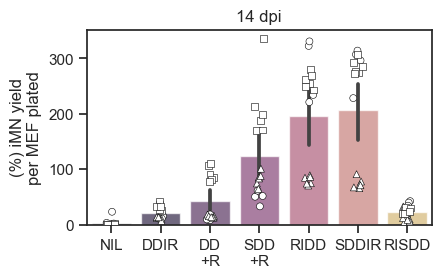

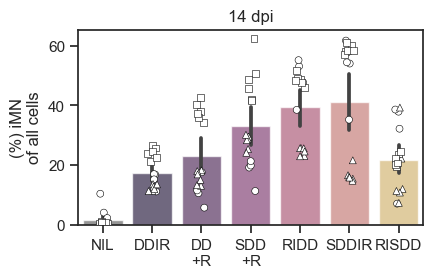

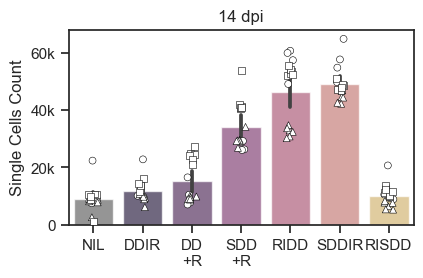

In [82]:
sns.set_theme(style="ticks",font_scale=1)
reps_14dpi = ['2024.03.11', '2022.08.20', '2022.10.31']
reps_WB = ['2023.07.14','2023.09.06']

for i in data2plot:
    savetitle = savedict[i]
    plottitle = '14 dpi'
    custom_barplot('mod_names',i,summary_df[summary_df['rep'].isin(reps_14dpi)],savetitle,
                    plottitle=plottitle,
                    height=3,
                    width=4.6,#5.2,
                    order=cassette_order,#order_cassette,
                    palette=palette,
                    reps='rep',
                    alpha=0.7,
                    xlabel_rot=0)

# Cassette Western Blot Quantification

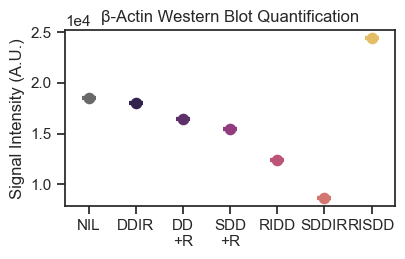

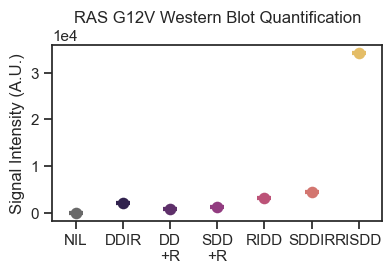

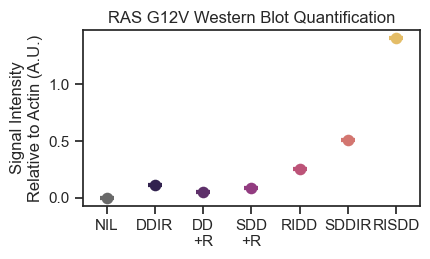

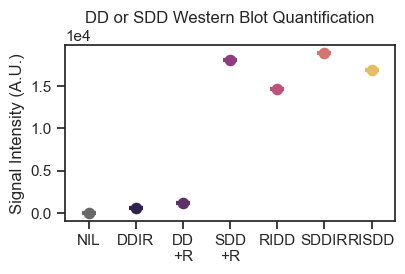

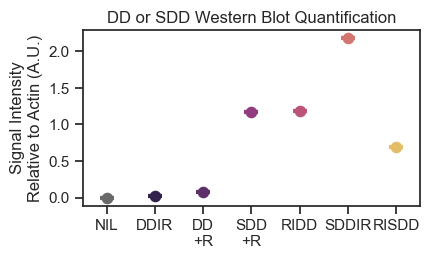

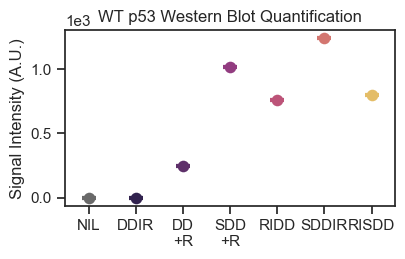

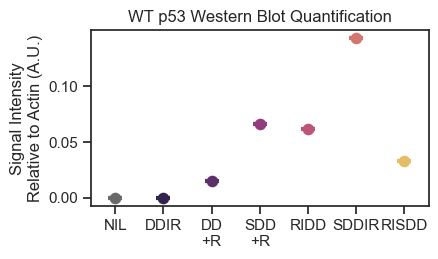

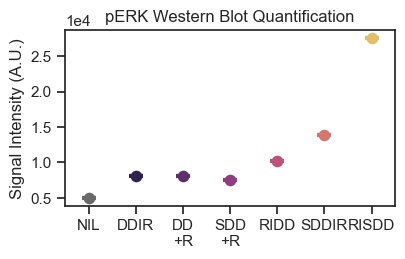

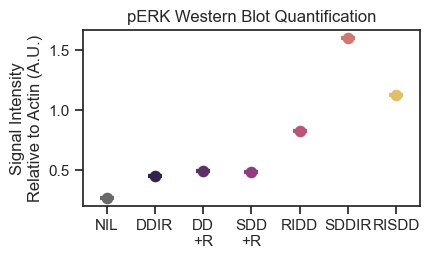

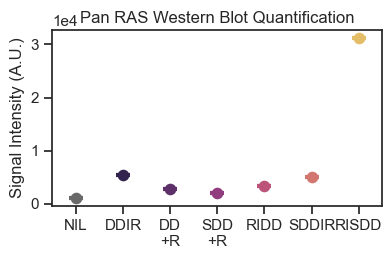

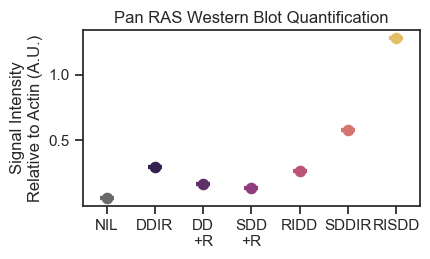

In [83]:
order_cassette = ['NIL','DDIR','DD RAS','SNAP-DD RAS','RIDD','SDDIR','RISDD']
protein = ['β-Actin', 'RAS G12V',
            'DD or SDD', 'WT p53', 'pERK', 'Pan RAS']

for p in protein:
    plottitle = p + ' Western Blot Quantification'

    slice = df_WB[df_WB['protein']==p] 
    slice = slice.rename(columns={'Signal Intensity Relative to Actin (A.U.)': 'Signal Intensity\nRelative to Actin (A.U.)'})
    savetitle = p + '_western'
    custom_catplot('mod_names','Signal Intensity (A.U.)',slice,savetitle,
                    plottitle=plottitle,
                    height=2.7,#3,
                    width=4.4,#4.8,
                    order=cassette_order,#order_cassette,
                    palette=palette,
                    xlabel_rot=0)
    
    if p != 'β-Actin':
       savetitle = p + '_normalized_western'
       custom_catplot('mod_names','Signal Intensity\nRelative to Actin (A.U.)',slice,savetitle,
                     plottitle=plottitle,
                     height=2.7,#3,
                     width=4.5,#4.8,
                     order=cassette_order,#order_cassette,
                     palette=palette,
                     xlabel_rot=0)

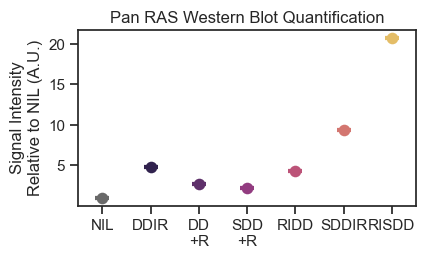

In [63]:

p = 'Pan RAS'
plottitle = p + ' Western Blot Quantification'
savetitle = p + '_NIL_normalized_western'
slice = df_WB[df_WB['protein']==p] 
slice = slice.rename(columns={'Signal Intensity Relative to NIL (A.U.)': 'Signal Intensity\nRelative to NIL (A.U.)'})
custom_catplot('mod_names','Signal Intensity\nRelative to NIL (A.U.)',slice,savetitle,
                plottitle=plottitle,
                height=2.7,
                width=4.5,
                order=cassette_order,
                palette=palette,
                xlabel_rot=0)


# Calculate mean and error for scatter plots (new WBs)

In [57]:
df_WB= df_WB.rename(columns={'Sample':'cassette','Protein':'protein'}) # Fix column naming

# Find the mean and standard error of the mean (SEM) for all technical and biological replicates in a given condition:
means = summary_df.groupby('cassette').mean(numeric_only=True)
se = summary_df.groupby('cassette').sem(numeric_only=True)
se.columns = [str(col) + ' SEM' for col in se.columns] # Rename the columns to include standard error of the mean
stats = means.join(se) # Combine means and standard errors into a single dataframe
stats.reset_index(drop=False,inplace=True) # Remove index
stats = pd.merge(stats, df_WB, on='cassette') # just join stats df with WB df directly because there is only 1 rep anyway
stats['Signal Intensity (A.U.) SEM'] = 0
stats['Signal Intensity Relative to Actin (A.U.) SEM'] = 0

# Scatter plots for WB

RAS G12V


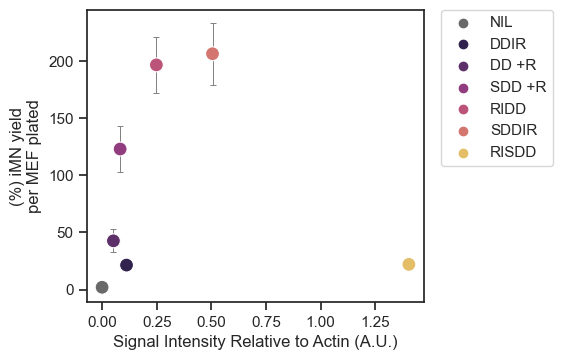

RAS G12V


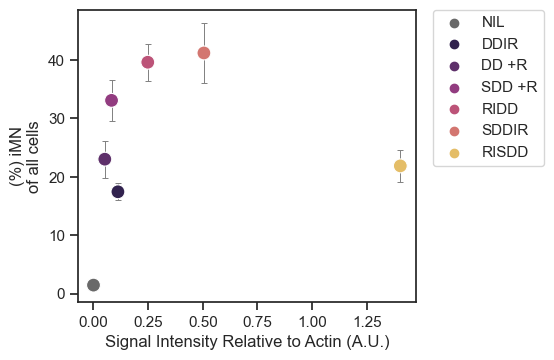

In [72]:
protein = ['RAS G12V']

xcat = 'Signal Intensity Relative to Actin (A.U.)'
for p in protein:
    for ycat in ['(%) iMN yield\nper MEF plated','(%) iMN\nof all cells']:
        savetitle = savedict[ycat] + '_' + xcat + '_' + p
        print(p)
        scatter(xcat,ycat,stats[(stats.protein == p)],
                order=cassette_order,
                hue='mod_names',
                savetitle=savetitle,
                palette=palette,
                figsize=(4.5,4.5))#,log='x')

# Plot DD and SNAP-DD for figure 1

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL vs. DD +R: t-test independent samples, P_val:3.860e-04 t=-3.996e+00
DD +R vs. SDD +R: t-test independent samples, P_val:1.393e-03 t=-3.522e+00
NIL vs. SDD +R: t-test independent samples, P_val:1.870e-06 t=-5.895e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL vs. DD +R: t-test independent samples, P_val:1.922e-07 t=-6.716e+00
DD +R vs. SDD +R: t-test independent samples, P_val:4.019e-02 t=-2.145e+00
NIL vs. SDD +R: t-test independent samples, P_val:6.043e-10 t=-8.924e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL vs. DD +R: t-

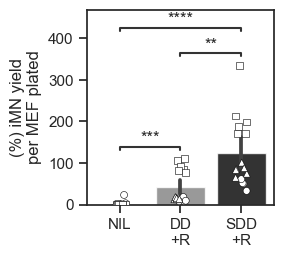

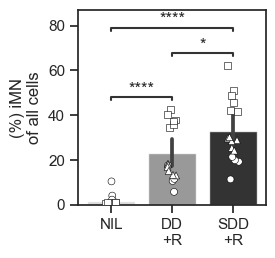

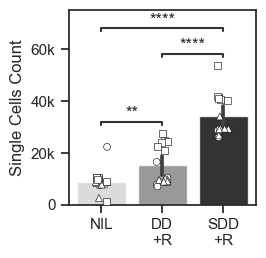

In [70]:
order = ['NIL','DD +R','SDD +R']
pairs = [('NIL','DD +R'),
          ('DD +R','SDD +R'),
          ('NIL','SDD +R')]

for i in data2plot:
    savetitle = 'DDvSDD_' + savedict[i]
    custom_barplot('mod_names',i,summary_df,savetitle,
                    order = order,
                    palette={'NIL':'lightgray','DD +R':'grey','SDD +R':'black'},
                    height=3,
                    width=2.5,
                    xlabel_rot=0,
                    alpha=0.8,
                    reps='rep',
                    pairs=pairs)
